<a href="https://colab.research.google.com/github/MintPst/Breast-cancer-segmentation/blob/main/20230513_Breast_cancer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install transformers 
!pip install accelerate
!pip install datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# อัพโหลด kaggle.json ที่หาได้จาก https://www.kaggle.com/settings (ไปที่หน้านี้แล้วกด "Create New Token" ใน section API)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset
!unzip breast-ultrasound-images-dataset.zip

breast-ultrasound-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  breast-ultrasound-images-dataset.zip
replace Dataset_BUSI_with_GT/benign/benign (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
from transformers import SegformerForSemanticSegmentation
from transformers import SegformerFeatureExtractor
from transformers import TrainingArguments, Trainer
from torchvision.transforms import ColorJitter, Resize, Compose

import torch
from torch import nn
import evaluate
import datasets
from datasets import Dataset, Features
import numpy as np

import os.path as op
from glob import glob
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
import os

In [ ]:
paths = glob("Dataset_BUSI_with_GT/*/*")  # get all folders: normal, benign, malignant
im_paths = [path for path in paths if "_mask" not in path]
data_paths = []

for path in im_paths:
    class_name = Path(path).parent.name
    seg_path = Path(Path(path).parent, Path(path).stem + "_mask.png")
    if op.exists(seg_path):
        data_paths.append({
            "img": path,
            "seg": str(seg_path),
            "class": class_name
        })
print("Length of image and segmentation paths = ", len(data_paths))

Length of image and segmentation paths =  780


In [ ]:
data_paths = {
    "img": [p["img"] for p in data_paths],
    "seg": [p["seg"] for p in data_paths],
    "class": [p["class"] for p in data_paths]
}
id2label = {0:"background", 1: "benign", 2: "malignant"}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
ds = Dataset.from_dict(data_paths, features=Features(
    {"img": datasets.Image(),
     "seg": datasets.Image(),
     "class": datasets.Value(dtype='string', id=None)}))
ds_split = ds.train_test_split(test_size=0.2)

In [ ]:
train_ds = ds_split["train"]
test_ds = ds_split["test"]

In [ ]:
feature_extractor = SegformerFeatureExtractor()

_transforms = Compose([
    ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),
])

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [ ]:
def train_transforms(example_batch):
    images = [_transforms(x) for x in example_batch["img"]]
    labels = []
    for segim, cls in zip(example_batch["seg"], example_batch["class"]):
        segim = np.array(segim).astype(int)
        if cls == "benign":
          segim[segim == 1] = 1
        elif cls == "malignant":
          segim[segim == 1] = 2
        else:
          pass
        if len(segim.shape) == 3:
          segim = segim[:, :, 0]
        labels.append(segim)
    inputs = feature_extractor(images, labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch["img"]]
    labels = []
    for segim, cls in zip(example_batch["seg"], example_batch["class"]):
        segim = np.array(segim).astype(int)
        if cls == "benign":
          segim[segim == 1] = 1
        elif cls == "malignant":
          segim[segim == 1] = 2
        else:
          pass
        if len(segim.shape) == 3:
          segim = segim[:, :, 0]
        labels.append(segim)
    inputs = feature_extractor(images, labels)
    return inputs

In [ ]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

In [ ]:
num_labels = len(id2label)
metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics

In [ ]:
pretrained_model_name = "nvidia/mit-b1" 
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at nvidia/mit-b1 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.linear_c.

In [ ]:
save_path = "segformer-breast-cancer_30ep"

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

n_epochs = 30

training_args = TrainingArguments(
    output_dir= save_path,
    learning_rate=6e-5,
    num_train_epochs=n_epochs,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=300,
    eval_steps=300,
    logging_steps=1,
    eval_accumulation_steps=5,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()
feature_extractor.save_pretrained(save_path)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Per Category Iou,Per Category Accuracy
300,0.135100,0.173218,0.575625,0.663913,0.949875,"[0.9577189686463062, 0.3654161267016635, 0.4037398692777174]","[0.9880312318991682, 0.4131602521751789, 0.5905466474094787]"
600,0.063000,0.123394,0.655124,0.741059,0.960225,"[0.9651681973687131, 0.5482178624290311, 0.45198552192123087]","[0.988031125983444, 0.666919924302655, 0.5682245970105674]"
900,0.068100,0.106887,0.692630,0.784335,0.964447,"[0.9683977578513652, 0.6052410080375241, 0.5042505834846933]","[0.9873421177187077, 0.7198554359875928, 0.6458065337880969]"
1200,0.039900,0.113075,0.680075,0.784005,0.962219,"[0.9674341087810079, 0.5939985397468294, 0.47879364598984736]","[0.9855549222677881, 0.6641232657357535, 0.7023364113549875]"
1500,0.025400,0.134243,0.648782,0.761252,0.958072,"[0.9657355660251146, 0.5445816520005834, 0.4360278241726108]","[0.9841712392470716, 0.6020760780712854, 0.6975089551138187]"
1800,0.041200,0.116438,0.697535,0.770609,0.966185,"[0.9694967790791772, 0.6289003648644214, 0.4942077101560031]","[0.9909532878557693, 0.7081609800342654, 0.6127137663320494]"
2100,0.018200,0.118573,0.702936,0.781090,0.966600,"[0.9700396990563689, 0.6290678851226291, 0.5097005191256179]","[0.9901619120436108, 0.7162581324255625, 0.6368503026750261]"


Trainer is attempting to log a value of "[0.9577189686463062, 0.3654161267016635, 0.4037398692777174]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9880312318991682, 0.4131602521751789, 0.5905466474094787]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9651681973687131, 0.5482178624290311, 0.45198552192123087]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.988031125983444, 0.666919924302655, 0.5682245970105674]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of 

['segformer-breast-cancer_30ep/preprocessor_config.json']

In [ ]:
# [optional] copy preprocessor_config.json to the model path folder
!cp segformer-breast-cancer_30ep/preprocessor_config.json segformer-breast-cancer_30ep/checkpoint-2100/preprocessor_config.json 

In [ ]:
print(save_path)
model_path = f"{save_path}/checkpoint-2100" 
image_processor = feature_extractor.from_pretrained(f"{save_path}/preprocessor_config.json", local_files_only=True) 
model = SegformerForSemanticSegmentation.from_pretrained(f"{model_path}",id2label=id2label, label2id=label2id, local_files_only=True)  

segformer-breast-cancer_30ep


/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [ ]:
ds = Dataset.from_dict(data_paths, features=Features(
    {"img": datasets.Image(),
     "seg": datasets.Image(),
     "class": datasets.Value(dtype='string', id=None)}))
ds_split = ds.train_test_split(test_size=0.2)
train_ds = ds_split["train"]
test_ds = ds_split["test"]

(-0.5, 510.5, 471.5, -0.5)

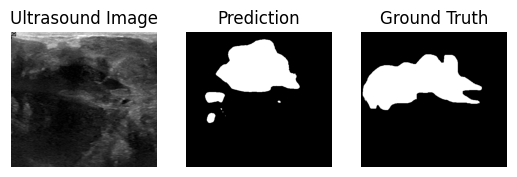

In [ ]:
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

image = test_ds[22]['img']
gt_seg = test_ds[22]['seg']

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

upsampled_logits = nn.functional.interpolate(
    logits,
    size=(image.size[1], image.size[0]),
    mode="bilinear",
    align_corners=False,
)
pred_seg = upsampled_logits.argmax(dim=1)[0]

plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Ultrasound Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pred_seg, cmap="gray")
plt.title("Prediction")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(gt_seg, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

In [ ]:
image = Image.open("./Dataset_BUSI_with_GT/benign/benign (1).png")
gt = Image.open("./Dataset_BUSI_with_GT/benign/benign (1)_mask.png")

In [ ]:
from transformers import pipeline

segmenter = pipeline("image-segmentation", model=model_path)
segmenter(image)

[{'score': None,
  'label': 'background',
  'mask': <PIL.Image.Image image mode=L size=562x471 at 0x7F8B104AFC40>},
 {'score': None,
  'label': 'benign',
  'mask': <PIL.Image.Image image mode=L size=562x471 at 0x7F8B104AFCA0>}]

In [ ]:
encoding = feature_extractor(image, return_tensors="pt")
pixel_values = encoding.pixel_values

outputs = model(pixel_values=pixel_values)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

In [ ]:
def ade_palette():
  """Creates a label colormap used in ADE20K segmentation benchmark.
  Returns:
    A colormap for visualizing segmentation results.
  """
  return np.asarray([
      [0, 0, 0],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
  ])

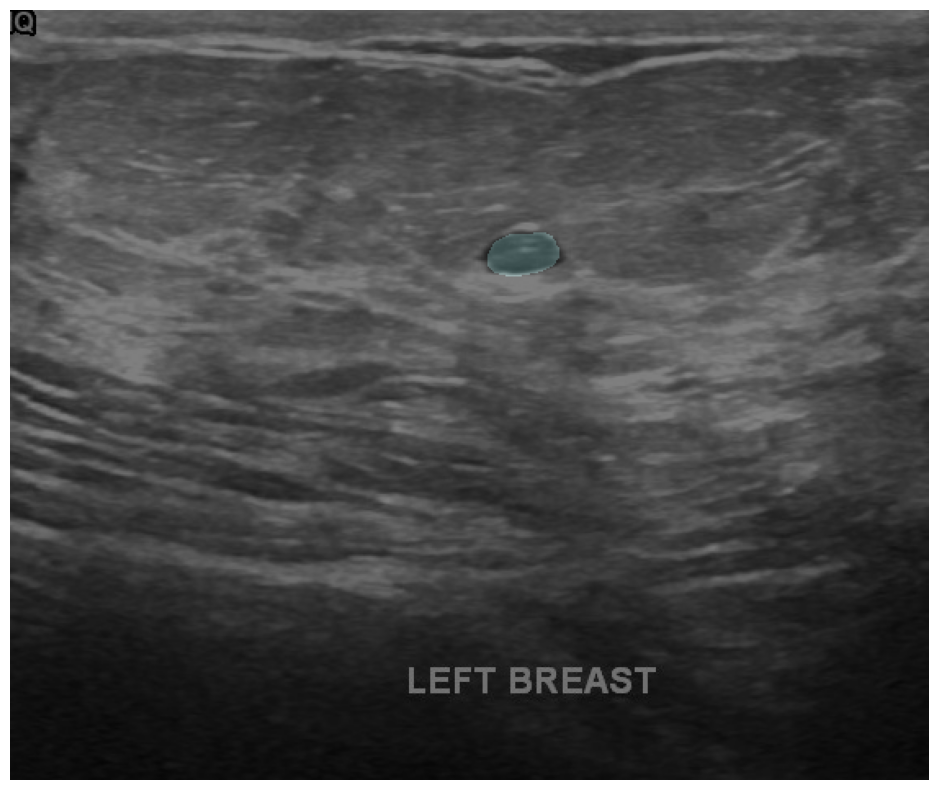

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to BGR

img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
history = trainer.state.log_history

In [ ]:
[r['loss'] for r in history[0:10]]

[1.0575, 1.035, 1.0272, 1.0234, 0.9915, 1.0, 0.9511, 0.9839, 0.9545, 0.9185]

In [ ]:
history[-1]

{'train_runtime': 3736.3633,
 'train_samples_per_second': 5.01,
 'train_steps_per_second': 0.626,
 'total_flos': 1.2082073520675226e+18,
 'train_loss': 0.1064184112729043,
 'epoch': 30.0,
 'step': 2340}

In [ ]:
history[290:310]

[{'loss': 0.1478,
  'learning_rate': 5.253846153846154e-05,
  'epoch': 3.73,
  'step': 291},
 {'loss': 0.1833,
  'learning_rate': 5.251282051282052e-05,
  'epoch': 3.74,
  'step': 292},
 {'loss': 0.2443,
  'learning_rate': 5.248717948717949e-05,
  'epoch': 3.76,
  'step': 293},
 {'loss': 0.1777,
  'learning_rate': 5.2461538461538464e-05,
  'epoch': 3.77,
  'step': 294},
 {'loss': 0.1505,
  'learning_rate': 5.2435897435897435e-05,
  'epoch': 3.78,
  'step': 295},
 {'loss': 0.1446,
  'learning_rate': 5.241025641025641e-05,
  'epoch': 3.79,
  'step': 296},
 {'loss': 0.2252,
  'learning_rate': 5.238461538461539e-05,
  'epoch': 3.81,
  'step': 297},
 {'loss': 0.1885,
  'learning_rate': 5.235897435897436e-05,
  'epoch': 3.82,
  'step': 298},
 {'loss': 0.1675,
  'learning_rate': 5.2333333333333336e-05,
  'epoch': 3.83,
  'step': 299},
 {'loss': 0.1351,
  'learning_rate': 5.230769230769231e-05,
  'epoch': 3.85,
  'step': 300},
 {'eval_loss': 0.17321845889091492,
  'eval_mean_iou': 0.5756249882

Text(0, 0.5, 'Loss')

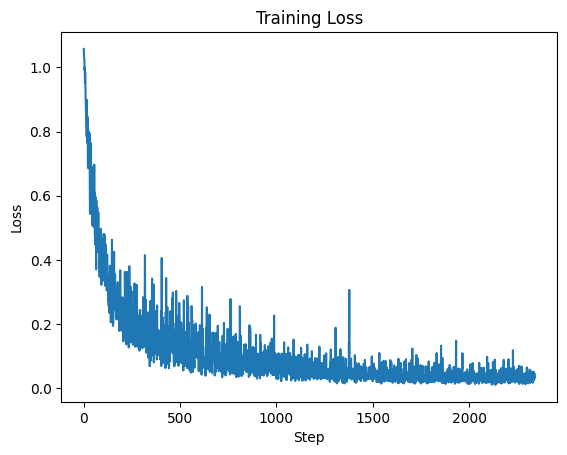

In [ ]:
x1 = [r["step"] for r in history if "loss" in r.keys()]
y1 = [r["loss"] for r in history if "loss" in r.keys()]
plt.title('Training Loss')
plt.plot(x1, y1)
plt.xlabel("Step")
plt.ylabel("Loss")

Text(0.5, 0, 'Step')

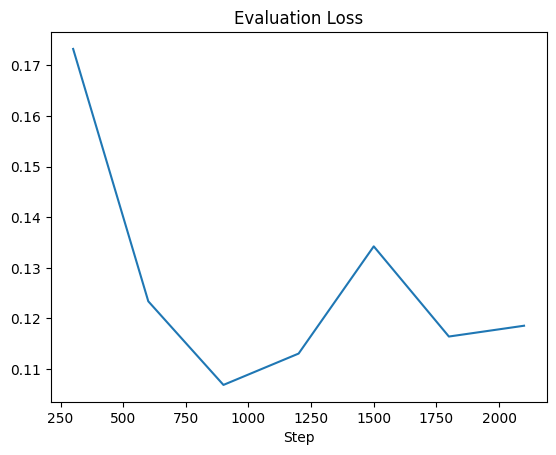

In [ ]:
x = [r["step"] for r in history if "eval_loss" in r.keys()]
y2 = [r["eval_loss"] for r in history if "eval_loss" in r.keys()]
plt.title('Evaluation Loss')
plt.plot(x, y2)
plt.xlabel("Step")

Text(0.5, 0, 'Step')

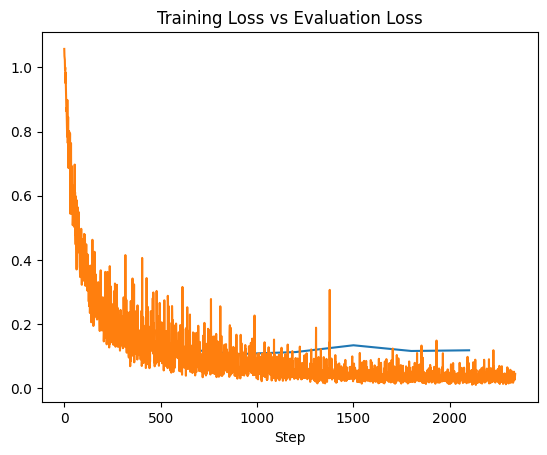

In [ ]:
x = [r["step"] for r in history if "eval_loss" in r.keys()]
y1 = [r["eval_loss"] for r in history if "eval_loss" in r.keys()]
y2 = [r["loss"] for r in history if "loss" in r.keys()]
plt.title('Training Loss vs Evaluation Loss')
plt.plot(x, y1, y2)
plt.xlabel("Step")

Text(0.5, 0, 'Step')

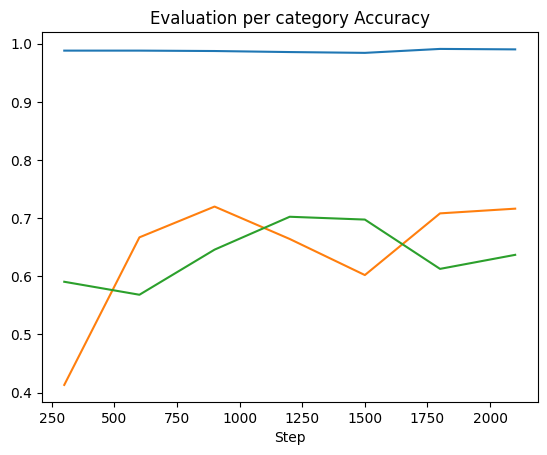

In [ ]:
x3 = [r["step"] for r in history if "eval_per_category_accuracy" in r.keys()]
y3 = [r["eval_per_category_accuracy"] for r in history if "eval_per_category_accuracy" in r.keys()]
plt.title('Evaluation per category Accuracy')
plt.plot(x3, y3)
plt.xlabel("Step")

Text(0.5, 0, 'Step')

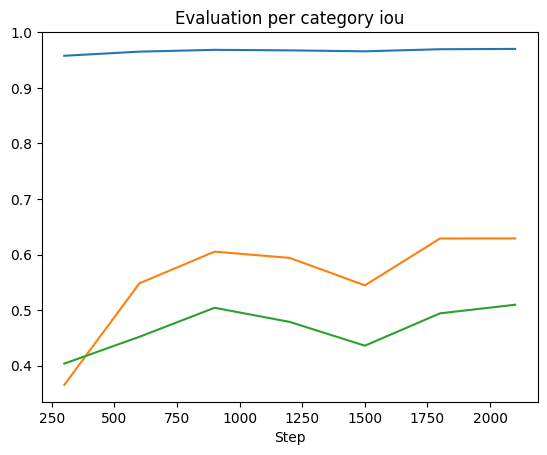

In [ ]:
x3 = [r["step"] for r in history if "eval_per_category_iou" in r.keys()]
y4 = [r["eval_per_category_iou"] for r in history if "eval_per_category_iou" in r.keys()]
plt.title('Evaluation per category iou')
plt.plot(x3, y4)
plt.xlabel("Step")